In [23]:
import numpy as np
import math 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt 
import pandas as pd
import time

In [2]:
# Constast and masses of the objects

In [24]:
G = 6.67e-11 # m^3 * kg^-1 * s^-2 Gravitational constant
m = 1.0e4 # Mass if the light object in kg 
M = 1.0e9 # Mass of the heavy object in kg
R = 10000 # Radius of the orbit
uncertainty = 0.01 # Uncertainty that is going to be introduced in the angle,radius and velocity

In [4]:
# Using the initial condition that we have been given we can calculate the initial velocity and the period

Requiring that gravity is equal to centripetal force (gmM/r^2 = (mv^2)/r) will give us the initial velocity for the period we can calculate it from (v=ωr (=) v = 2πr/T (=) T=2πr/v).
Since it has been asked that the whole simulation should last at least 10 periods I chose the total time of the simulation to be 19 periods. The number of steps that has been chosen is 10000.

In [25]:
initial_velocity = np.sqrt((G*M/R))
period = 2*np.pi*R/initial_velocity
total_time = period * 19
time_step = total_time / 10000
num_steps = 10000


This function calculates the coordinates and velocities by splitting them into x and y components and then adds uncertainty into the radius, angle, and velocities. The calculation is done using the Euler method. x,y,vx and vy correspond to the coodrdinates and the velocities of the light object.

In [6]:
def simulate_two_body(total_time, time_step):
    
    x_heavy,y_heavy = 0,0
    x, y = 0, R
    vx, vy = initial_velocity, 0
    coordinates = np.zeros((num_steps, 2))
    velocities = np.zeros((num_steps, 2))
    abs_velocity = np.zeros(num_steps)
    
    for t_idx in range(num_steps):
        r = np.sqrt((x-x_heavy)**2 + (y-y_heavy)**2) * (1 + np.random.uniform(-uncertainty, uncertainty))
        
        F = -G * M * m / r**2
        
        angle = np.arctan2(y, x) * (1 + np.random.uniform(-uncertainty, uncertainty))
        
        Fx = F * np.cos(angle)
        Fy = F * np.sin(angle)
        
        ax = Fx / m
        ay = Fy / m
        vx += ax * time_step * (1 + np.random.uniform(-uncertainty, uncertainty))
        vy += ay * time_step * (1 + np.random.uniform(-uncertainty, uncertainty))
        
        x += vx * time_step
        y += vy * time_step
        
        coordinates[t_idx] = [x, y]
        velocities[t_idx] = [vx, vy]
        abs_velocity[t_idx] = np.sqrt(vx**2 + vy**2)
    
    return coordinates, velocities, abs_velocity

The following functions format the simulation data and save it to the specified file path. The data is saved in a specific format, and the function also reads the data back from the file to prepare it for further use.

In [7]:

def save_and_prepare_data(sequence_number, coordinates, velocities, file_path):
    def format_data(sequence_number, coordinates, velocities):
        formatted_data = []
        for i in range(len(coordinates)):
            x, y = coordinates[i]
            vx, vy = velocities[i]
            line = f"{sequence_number},{x},{y},{vx},{vy}\n"
            formatted_data.append(line)
            sequence_number += 1
        return formatted_data

    # Format and save data
    formatted_data = format_data(sequence_number, coordinates, velocities)
    
    with open(file_path, "w") as file:
        file.writelines(formatted_data)

    # Read the data back from the file
    data = pd.read_csv(file_path, header=None, names=["sequence", "x", "y", "vx", "vy"])

    coordinates = data[["x", "y"]].values
    abs_velocity = np.sqrt(data["vx"]**2 + data["vy"]**2).values

    return coordinates, abs_velocity, data

Takes the data from the simulation and plots the trajectory and the absolute value of the velocity over time.

In [8]:
def plot_orbiting_body(data, total_time, title="Trajectory of the Orbiting Body"):
    coordinates = data[["x", "y"]].values
    abs_velocity = np.sqrt(data["vx"]**2 + data["vy"]**2).values
    time_values = np.linspace(0, total_time, num=len(data))

    # Plot trajectory
    plt.figure()
    plt.plot(coordinates[:, 0], coordinates[:, 1])
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('Trajectory of the Orbiting Body')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

    # Plot velocity
    plt.figure()
    plt.plot(time_values, abs_velocity)
    plt.xlabel('Time (s)')
    plt.ylabel('Abs_Velocity (m/s)')
    plt.title('Velocity of the Orbiting Body')
    plt.grid(True)
    plt.show()

1.A) Simulation of the light body orbiting around the heavy one for 10000 time steps with initial coordinates x= 0 and y= 10000

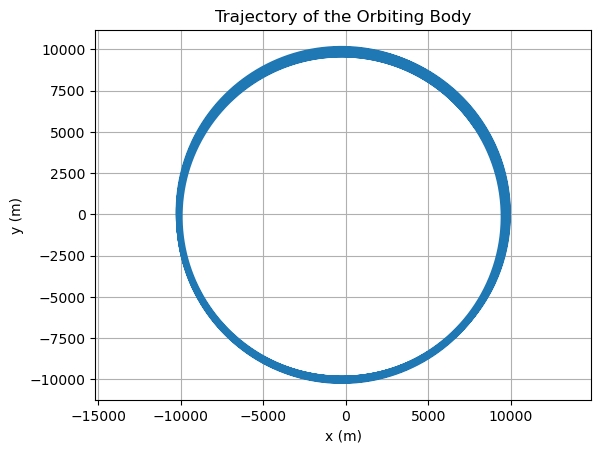

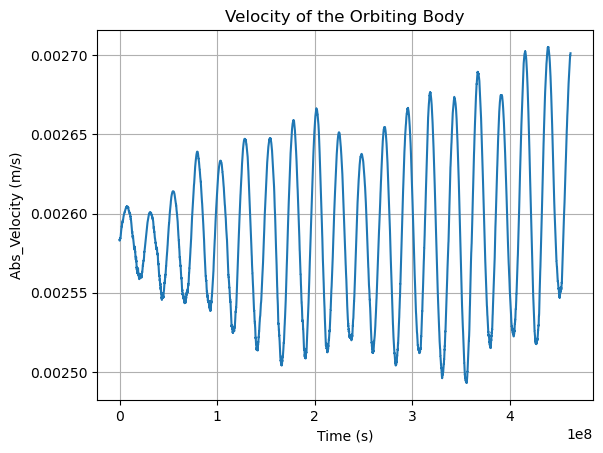

In [11]:
file_path = r"C:\Users\user\Downloads\simulation_data_1a.csv"
sequence_number = 1
coordinates_1a, velocities_1a, _ = simulate_two_body(total_time, time_step)
coordinates, abs_velocity, data = save_and_prepare_data(sequence_number, coordinates_1a, velocities_1a, file_path)
plot_orbiting_body(data, total_time)

This function simulates the motion of the light object with an additional sinusoidal force, keeping the initial velocity the same. It calculates the coordinates and velocities over time, incorporating the gravitational force and the sinusoidal acceleration in the x and y directions.

In [9]:

def simulate_with_specified_acceleration_changes(total_time, time_step,f2_accelaration):
  
    x_heavy , y_heavy = 0,0
    x, y = 0, R
    vx, vy = initial_velocity, 0  # Perpendicular velocity
   

    coordinates = np.zeros((num_steps, 2))
    velocities = np.zeros((num_steps, 2))
    abs_velocity = np.zeros(num_steps)

    for t_idx in range(num_steps):
        r = np.sqrt((x-x_heavy)**2 + (y-y_heavy)**2) * (1 + np.random.uniform(-uncertainty, uncertainty))
        F = -G * M * m / r**2
        angle = np.arctan2(y, x) * (1 + np.random.uniform(-uncertainty, uncertainty))
        Fx = F * np.cos(angle)
        Fy = F * np.sin(angle)

        # Add sinusoidal acceleration
        Fx += f2_accelaration * np.sin(vx)
        Fy += f2_accelaration * np.sin(vy)

        ax = Fx / m
        ay = Fy / m

        vx += ax * time_step * (1 + np.random.uniform(-uncertainty, uncertainty))
        vy += ay * time_step * (1 + np.random.uniform(-uncertainty, uncertainty))

        x += vx * time_step
        y += vy * time_step

        coordinates[t_idx] = [x, y]
        velocities[t_idx] = [vx, vy]
        abs_velocity[t_idx] = np.sqrt(vx**2 + vy**2) 

    return coordinates, velocities, abs_velocity


The loop runs for all the different acceleration steps and saves the datasets. The acceleration is being increased by 10% in each step.

In [11]:
base_acceleration = 5e-9
sequence_number= 1
# Loop through different acceleration steps and save datasets
acceleration_steps = [1, 1.1, 1.21, 1.331, 1.4641]  # Increasing by 10% each step

file_paths = []

for i, factor in enumerate(acceleration_steps):
    f2_acceleration = base_acceleration * factor
    coordinates_1b, velocities_1b, abs_velocity_1b = simulate_with_specified_acceleration_changes(total_time, time_step, f2_acceleration)
    
    file_path = f"C:\\Users\\user\\Downloads\\Simulation_1b_{factor:.3f}.csv"  # Format the file path with .csv extension and formatted factor
    coordinates, abs_velocity, data = save_and_prepare_data(sequence_number, coordinates_1b, velocities_1b, file_path)
    file_paths.append(file_path)



NameError: name 'sequence_number' is not defined

In [10]:
def plot_orbiting_body_b(data, total_time, title="Trajectory of the Orbiting Body"):
    coordinates = data[["x", "y"]].values
    abs_velocity = np.sqrt(data["vx"]**2 + data["vy"]**2).values
    time_values = np.linspace(0, total_time, num=len(data))

    # Plot trajectory
    plt.figure()
    plt.plot(coordinates[:, 0], coordinates[:, 1])
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(f"Trajectory of the Orbiting Body - {title}")
    plt.grid(True)
    plt.axis('equal')
    plt.show()

    # Plot velocity
    plt.figure()
    plt.plot(time_values, abs_velocity)
    plt.xlabel('Time (s)')
    plt.ylabel('Abs_Velocity (m/s)')
    plt.title(f"Velocity of the Orbiting Body - {title}")
    plt.grid(True)
    plt.show()




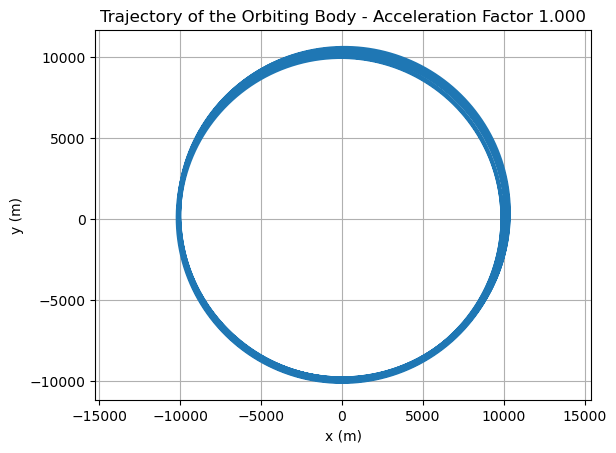

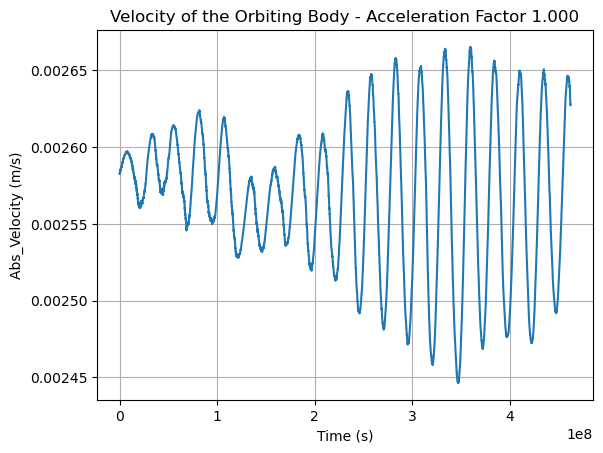

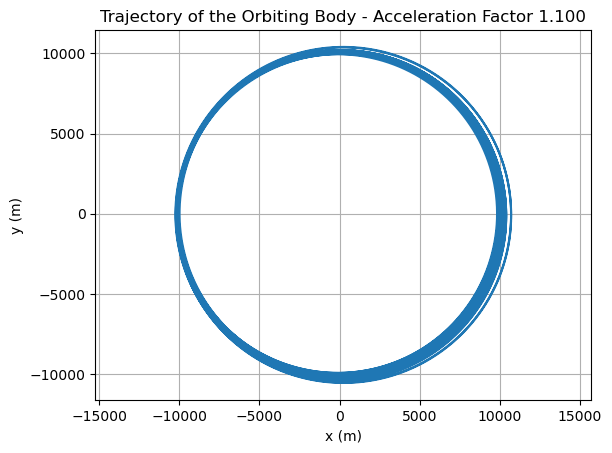

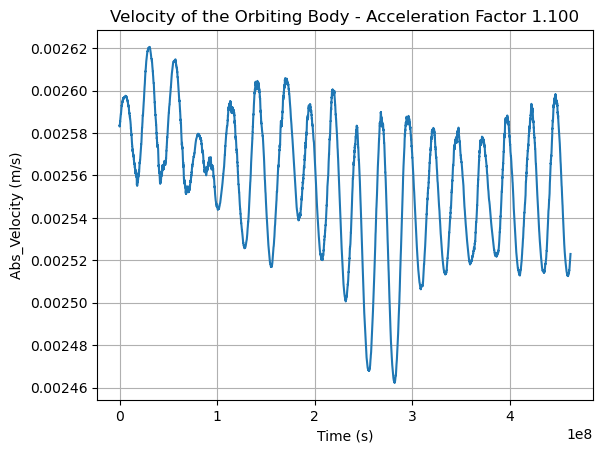

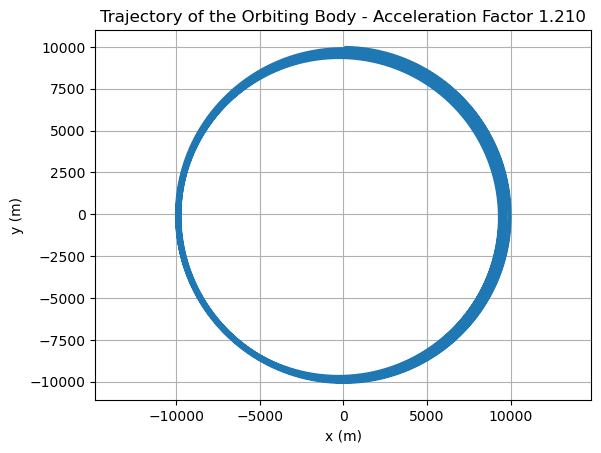

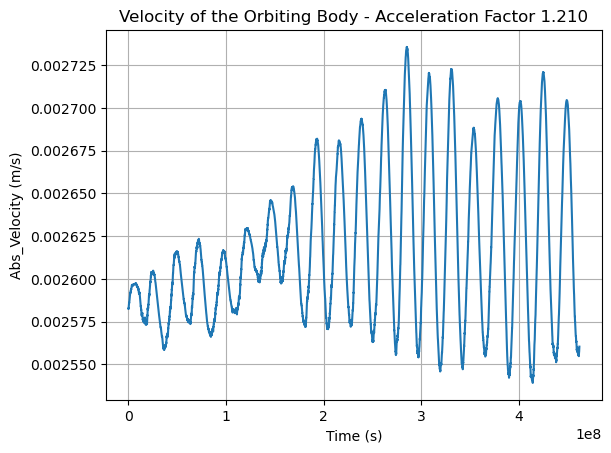

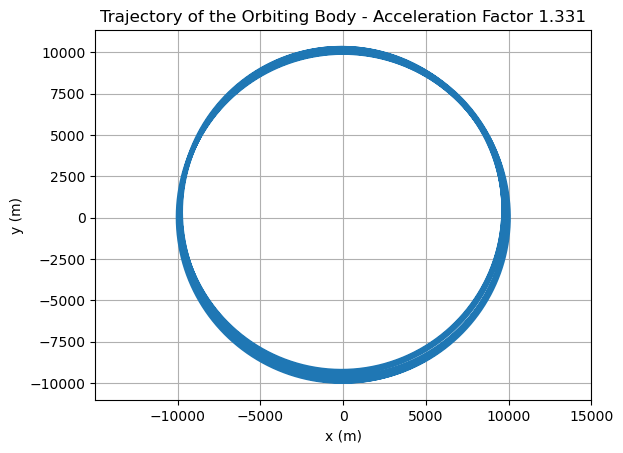

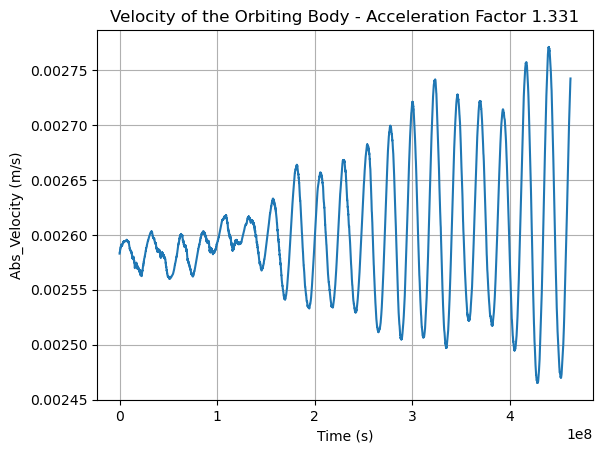

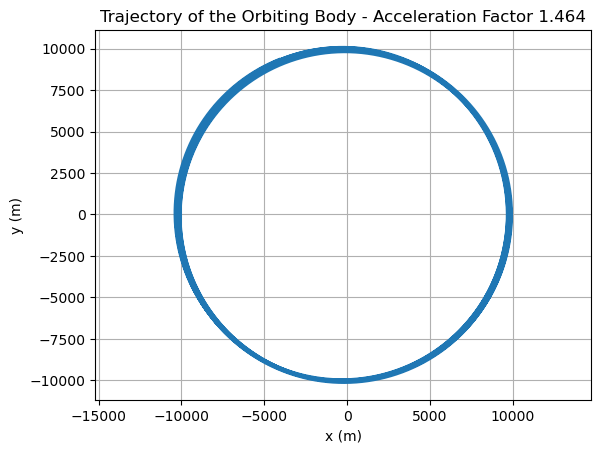

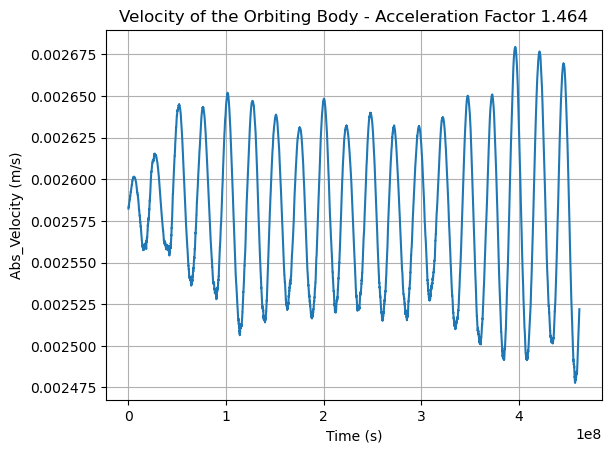

In [17]:
file_paths = [
    r"C:\Users\user\Downloads\Simulation_1b_1.000.csv",
    r"C:\Users\user\Downloads\Simulation_1b_1.100.csv",
    r"C:\Users\user\Downloads\Simulation_1b_1.210.csv",
    r"C:\Users\user\Downloads\Simulation_1b_1.331.csv",
    r"C:\Users\user\Downloads\Simulation_1b_1.464.csv"
]

for file_path in file_paths:
    data = pd.read_csv(file_path, header=None, names=["sequence", "x", "y", "vx", "vy"])
    file_name = file_path.split('\\')[-1]  
    acceleration_factor = file_name.split('_')[-1].replace('.csv', '') 
    plot_orbiting_body_b(data, total_time, title=f"Acceleration Factor {acceleration_factor}")


For the three-body system we have to introduce new initial coordinates for the space ship and the heavy bodies.

In [17]:
R1 = 10000  # x position of the first heavy body (m)
R2 = -10000  # x position of the second heavy body (m)
initial_y = 29400  # 30000*0,98 Initial y position of the spaceship (m)
initial_x = 0  # Initial x position of the spaceship (m)
uncertainty = 0.01  # 1% relative uncertainty




Simulation for the two-body system where x and y are the coordinates of the spaceship.

In [18]:
def simulate_two_body_system_with_two_heavy_bodies(total_time, time_step, initial_y, initial_velocity):
    num_steps = int(total_time / time_step)
    x, y = initial_x, initial_y
    vx, vy = initial_velocity , 0  

    coordinates = np.zeros((num_steps, 2))
    velocities = np.zeros((num_steps, 2))
    abs_velocity = np.zeros(num_steps)

    for t_idx in range(num_steps):
        
        r1 = np.sqrt((x - R1)**2 + y**2)* (1 + np.random.uniform(-uncertainty, uncertainty))
        r2 = np.sqrt((x - R2)**2 + y**2)* (1 + np.random.uniform(-uncertainty, uncertainty))
        angle1 = np.arctan2(y, x - R1)* (1 + np.random.uniform(-uncertainty, uncertainty))
        angle2 = np.arctan2(y, x - R2)* (1 + np.random.uniform(-uncertainty, uncertainty))
        
        
        F1 = -G * M * m / r1**2
        Fx1 = F1 * np.cos(angle1)
        Fy1 = F1 * np.sin(angle1)

        
        F2 = -G * M * m / r2**2
        Fx2 = F2 * np.cos(angle2)
        Fy2 = F2 * np.sin(angle2)

        # Total forces
        Fx = Fx1 + Fx2
        Fy = Fy1 + Fy2

        
        ax = Fx / m
        ay = Fy / m

        # Update velocities
        vx += ax * time_step* (1 + np.random.uniform(-uncertainty, uncertainty))
        vy += ay * time_step* (1 + np.random.uniform(-uncertainty, uncertainty))

       
        x += vx * time_step
        y += vy * time_step

        coordinates[t_idx] = [x, y]
        velocities[t_idx] = [vx, vy]
        abs_velocity[t_idx] = np.sqrt(vx**2 + vy**2)

    return coordinates, velocities, abs_velocity


In [ ]:
def plot_orbiting_body(data, total_time, title="Trajectory of the Orbiting Body"):
    coordinates = data[["x", "y"]].values
    abs_velocity = np.sqrt(data["vx"]**2 + data["vy"]**2).values
    time_values = np.linspace(0, total_time, num=len(data))

    
    plt.figure()
    plt.plot(coordinates[:, 0], coordinates[:, 1], label="Spaceship Trajectory")
    plt.scatter([R1, R2], [0, 0], color='red', s=100, marker='X', label="Heavy Objects")  
    plt.ylabel('y position (m)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


    plt.figure()
    plt.plot(time_values, abs_velocity)
    plt.xlabel('Time (s)')
    plt.ylabel('Abs_Velocity (m/s)')
    plt.title(f"Velocity of the Orbiting Body - {title}")
    plt.grid(True)
    plt.show()

Introducing a 5 % uncertainty in the initial y position and then run the simulation for 5 times. 

Saved dataset with initial_y 30159.767909399263 to C:\Users\user\Downloads\Simulation_two_body_30159.768.csv
Saved dataset with initial_y 28751.943823312595 to C:\Users\user\Downloads\Simulation_two_body_28751.944.csv
Saved dataset with initial_y 29025.07181780611 to C:\Users\user\Downloads\Simulation_two_body_29025.072.csv
Saved dataset with initial_y 28937.184221256197 to C:\Users\user\Downloads\Simulation_two_body_28937.184.csv
Saved dataset with initial_y 29355.399295919822 to C:\Users\user\Downloads\Simulation_two_body_29355.399.csv
Columns in C:\Users\user\Downloads\Simulation_two_body_30159.768.csv: Index(['sequence', 'x', 'y', 'vx', 'vy'], dtype='object')


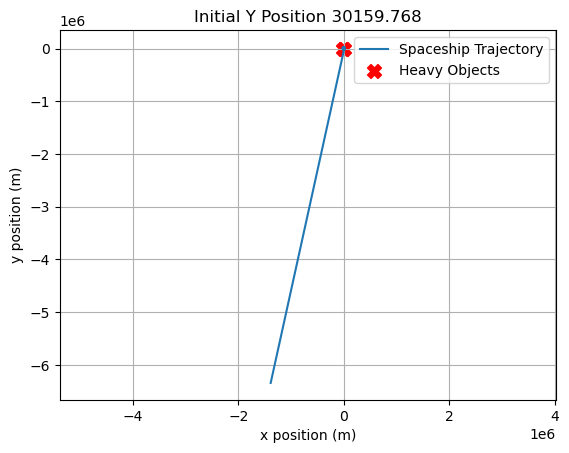

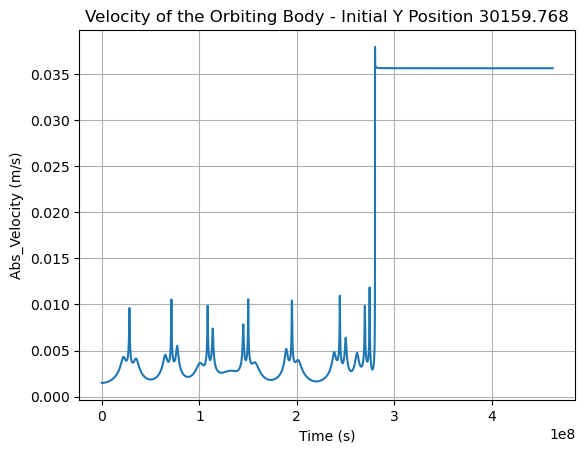

Columns in C:\Users\user\Downloads\Simulation_two_body_28751.944.csv: Index(['sequence', 'x', 'y', 'vx', 'vy'], dtype='object')


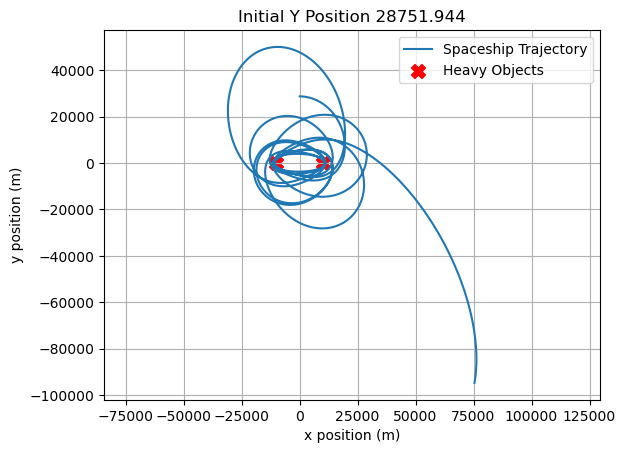

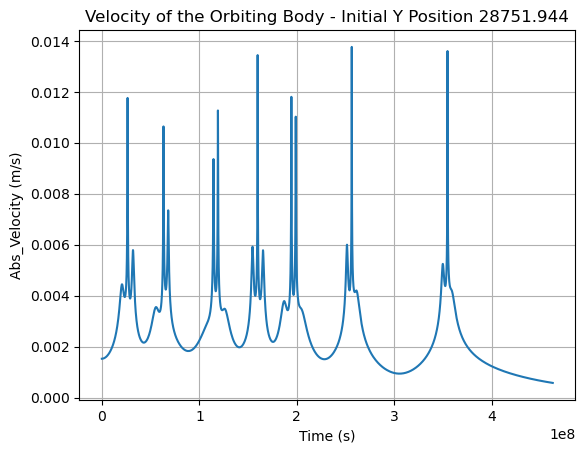

Columns in C:\Users\user\Downloads\Simulation_two_body_29025.072.csv: Index(['sequence', 'x', 'y', 'vx', 'vy'], dtype='object')


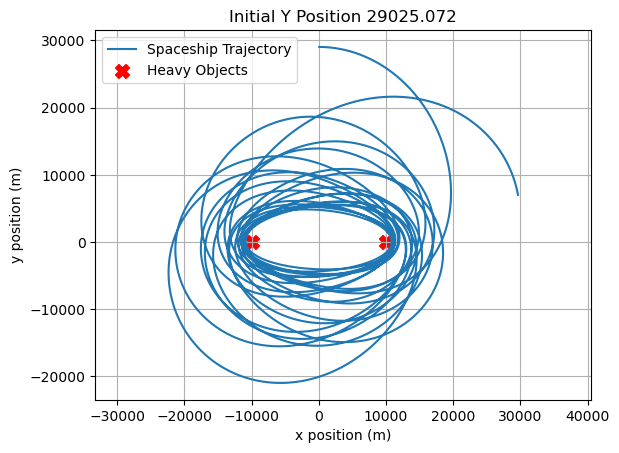

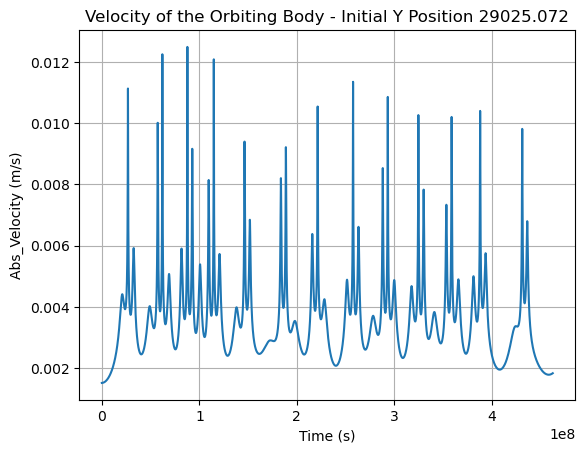

Columns in C:\Users\user\Downloads\Simulation_two_body_28937.184.csv: Index(['sequence', 'x', 'y', 'vx', 'vy'], dtype='object')


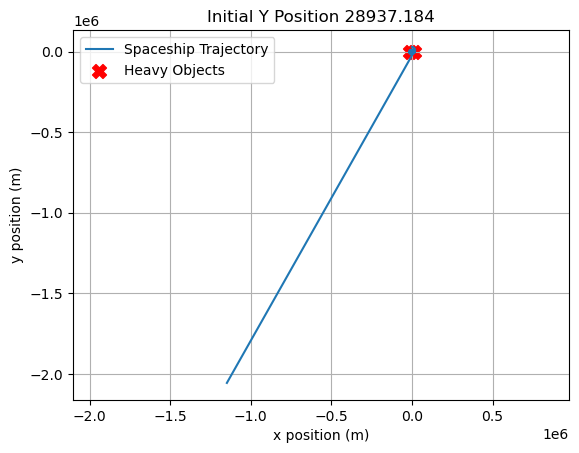

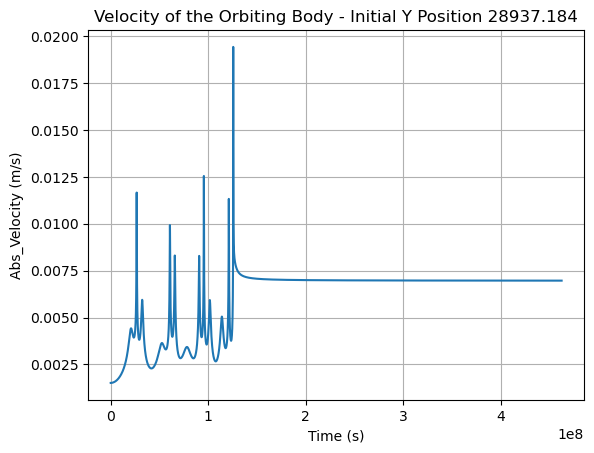

Columns in C:\Users\user\Downloads\Simulation_two_body_29355.399.csv: Index(['sequence', 'x', 'y', 'vx', 'vy'], dtype='object')


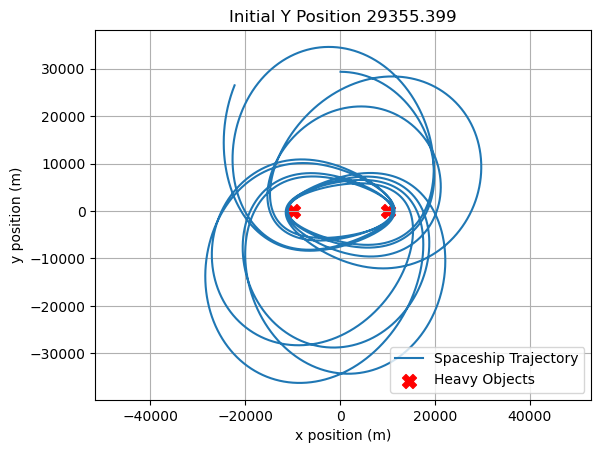

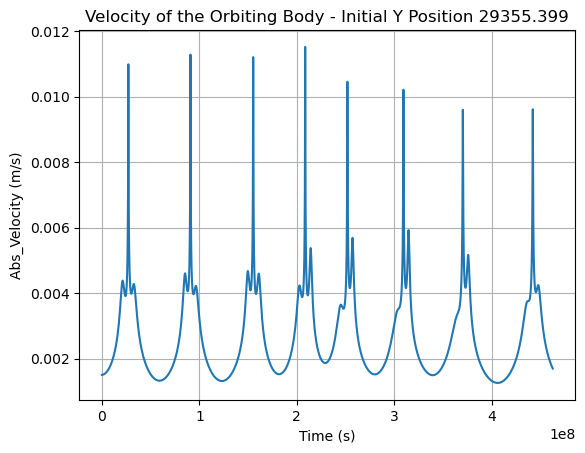

In [26]:
uncertainty_c = 0.05  # 5% uncertainty
initial_y_values = [initial_y * (1 + np.random.uniform(-uncertainty_c, uncertainty_c)) for _ in range(5)]
file_paths = []

for initial_y in initial_y_values:
    initial_velocity = np.sqrt((G * M / initial_y))
    coordinates, velocities, abs_velocity = simulate_two_body_system_with_two_heavy_bodies(total_time, time_step, initial_y, initial_velocity)
    
    
    file_path = f"C:\\Users\\user\\Downloads\\Simulation_two_body_{initial_y:.3f}.csv"
    
    
    coordinates, abs_velocity, data = save_and_prepare_data(sequence_number, coordinates, velocities, file_path)
    file_paths.append(file_path) 

# Plotting the results for each initial_y
for file_path in file_paths:
    data = pd.read_csv(file_path, header=None, names=["sequence", "x", "y", "vx", "vy"])
    
    # Remove the initial_y value from the filename for the title
    file_name = file_path.split('\\')[-1]
    initial_y_value = file_name.split('_')[-1].replace('.csv', '')
    
    plot_orbiting_body(data, total_time, title=f"Initial Y Position {initial_y_value}")


For the next part, training on the regression models will take place. The following function splits the data X into 3 positions and velocities and then saves the fourth positions and velocities in the y data. We want our model to predict the 4th position based on the last three. After that normalization takes place and lastly, data is separated into training, testing, and validation.

In [6]:
def create_and_normalize_sequences(data, n_steps=3):
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq_x = np.hstack((data[["x", "y", "vx", "vy"]].values[i:i+n_steps]))  # 3 steps of position and velocity
        seq_y = data[["x", "y", "vx", "vy"]].values[i+n_steps]  # Next position and velocity
        X.append(seq_x.flatten())
        y.append(seq_y)
    
    X = np.array(X)
    y = np.array(y)
    
    # Normalize the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y)
    
    return X, y, scaler_X, scaler_y


Splits the data into training, validation, and testing sets, with the test data starting from the 5000th index.

In [7]:
def splitting_data(X, y, test_start_index=5000, validation_size=0.2, random_state=42):
   
    X_train_val, X_test = X[:test_start_index], X[test_start_index:]
    y_train_val, y_test = y[:test_start_index], y[test_start_index:]

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=validation_size, random_state=random_state, shuffle=True
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


The training, evaluation, and predictions of the model occur in this function. The function also generates training history plots and calculates evaluation metrics, including mean absolute error (MAE) and root mean squared error (RMSE).

In [8]:
def train_and_evaluate_model(data, create_model_function, n_steps=3, test_start_index=5000, epochs=200):
    # Data preparation
    X, y, scaler_X, scaler_y = create_and_normalize_sequences(data, n_steps)
    X_train, X_val, X_test, y_train, y_val, y_test = splitting_data(X, y, test_start_index=test_start_index)
    
    # Determine the shape of the input data
    input_shape = X_train.shape[1]
    
    # Create and train the model using the provided create_model_function
    model = create_model_function(input_shape)
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
    
    # Plot the training history
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    predictions_denorm = scaler_y.inverse_transform(predictions)
    y_test_denorm = scaler_y.inverse_transform(y_test)
    
    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test_denorm, predictions_denorm)
    rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions_denorm))
    
    print(f'Model MAE: {mae}')
    print(f'Model RMSE: {rmse}')
    
    return model, predictions_denorm, mae, rmse, scaler_X, scaler_y, X_test, y_test

In [ ]:
# Model which is going to be used for the 1.a Dataset

In [9]:
def create_simple_dense_regression_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4)  # Four outputs: x, y positions and x, y velocities
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [7]:
# Model which is going to be used for the 1.b Dataset

In [9]:
def create_dense_regression_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4)  
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse')
    return model




In [9]:
#Model which is going to be used for the 1.c Dataset

In [29]:
def complex_dense_regression_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4)  
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse')
    return model

Starting with an initial input, it iteratively predicts the next time step and updates the input for the next prediction. The predictions are scaled back to their original values and returned as an array.

In [32]:
def predict_future_steps(model, start_input, steps, scaler_X, scaler_y):
    inputs = start_input.reshape(1, -1)
    predictions = []
    
    for step in range(steps):
        prediction = model.predict(inputs)
        predictions.append(prediction.flatten())
        # Update the input for the next prediction
        inputs = np.hstack((inputs[:, 4:], prediction)).reshape(1, -1)  # Remove the oldest time step and add the new prediction
    
    return np.array(predictions)




In [33]:
def plot_predictions(predictions, start_position, steps, y_test, title, scaler_y):
    time_steps = np.arange(start_position, start_position + steps)
    y_test_denorm = scaler_y.inverse_transform(y_test[:steps])
    predictions_denorm = scaler_y.inverse_transform(predictions)
    
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_denorm[:, 0], y_test_denorm[:, 1], label='Actual Trajectory')
    plt.plot(predictions_denorm[:, 0], predictions_denorm[:, 1], '--', label='Predicted Trajectory')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.title(title)
    plt.axis('equal')
    plt.show()



## Two-Body Problem with a Circular Orbit


I want to inform you that there is an error in the following line where I train and evaluate the model. As you can see the only input I give is data while the train_and_evaluate_model takes as input the data and the model you want to train. After I started tying up the code I figured out that I could simply use the model as input instead of defining every time I needed to train a new model. Luckily I saved the models and the line of codes before I made those changes because for some reason I was unable to figure out after the change I made all the models I  tried to train were bad.

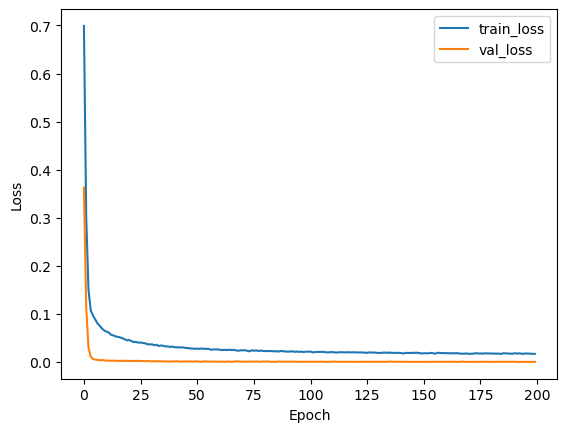

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Dense Model MAE: 57.064712940590915
Dense Model RMSE: 99.52999196384866


In [37]:
#data_path = r"C:\Users\user\Downloads\simulation_data_1a.csv"
#data = pd.read_csv(data_path, header=None, names=["sequence", "x", "y", "vx", "vy"])

#model, predictions_denorm, mae, rmse, scaler_X, scaler_y = train_and_evaluate_model(data)

In [40]:
#model_save_path = r"C:\Users\user\Downloads\dense_regression_model_a.keras"
#model.save(model_save_path)

In [10]:
#model_path = r"C:\Users\user\Downloads\dense_regression_model_a.keras"
#model = load_model(model_path)

In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,134 (35.68 KB)

 Trainable params: 3,044 (11.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,090 (23.79 KB)

In [38]:
data_path = r"C:\Users\user\Downloads\simulation_data_1a.csv"
data = pd.read_csv(data_path, header=None, names=["sequence", "x", "y", "vx", "vy"])
X, y, scaler_X, scaler_y = create_and_normalize_sequences(data, n_steps=3)
X_train, X_val, X_test, y_train, y_val, y_test = splitting_data(X, y, test_start_index=5000)
start_input = X_test[0]  # Index 0 after the split

predictions_10_dense = predict_future_steps(model, start_input, 10, scaler_X, scaler_y)
predictions_100_dense = predict_future_steps(model, start_input, 100, scaler_X, scaler_y)
predictions_500_dense = predict_future_steps(model, start_input, 500, scaler_X, scaler_y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

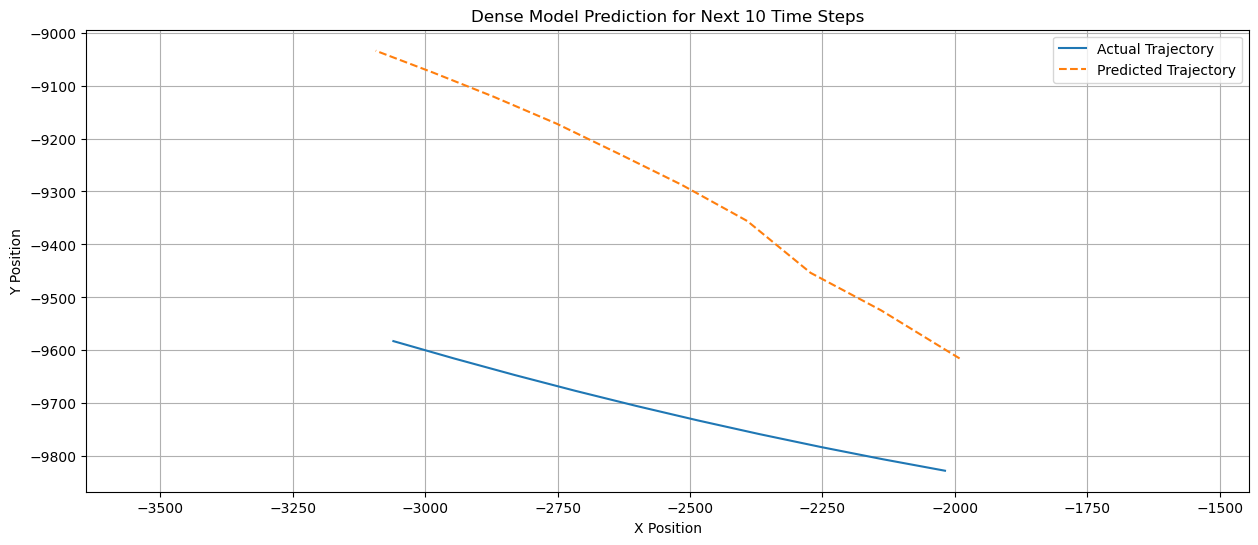

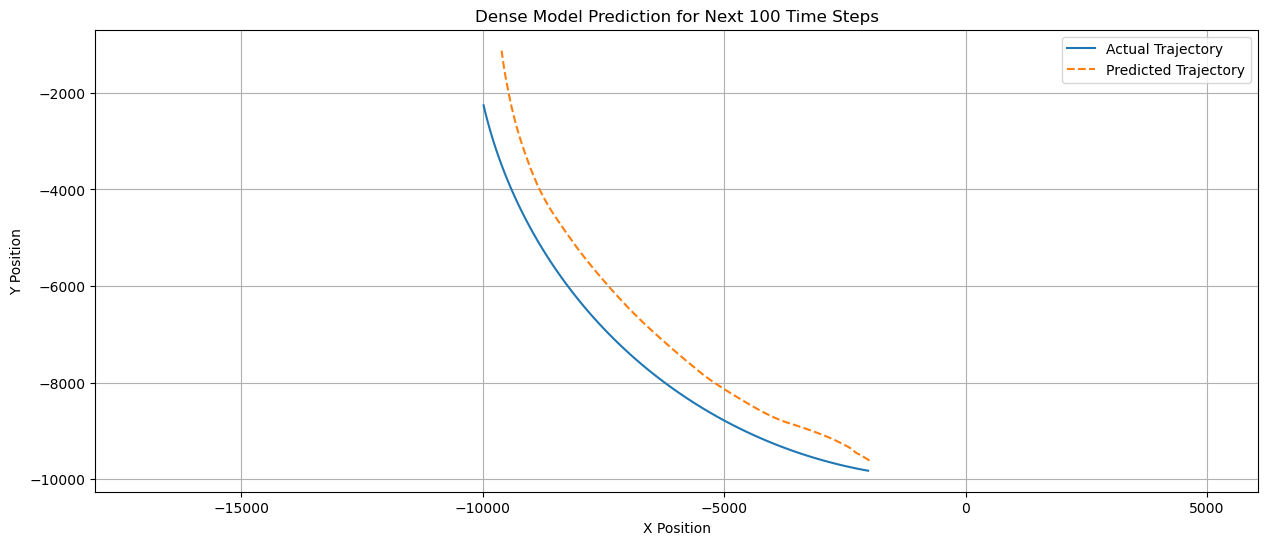

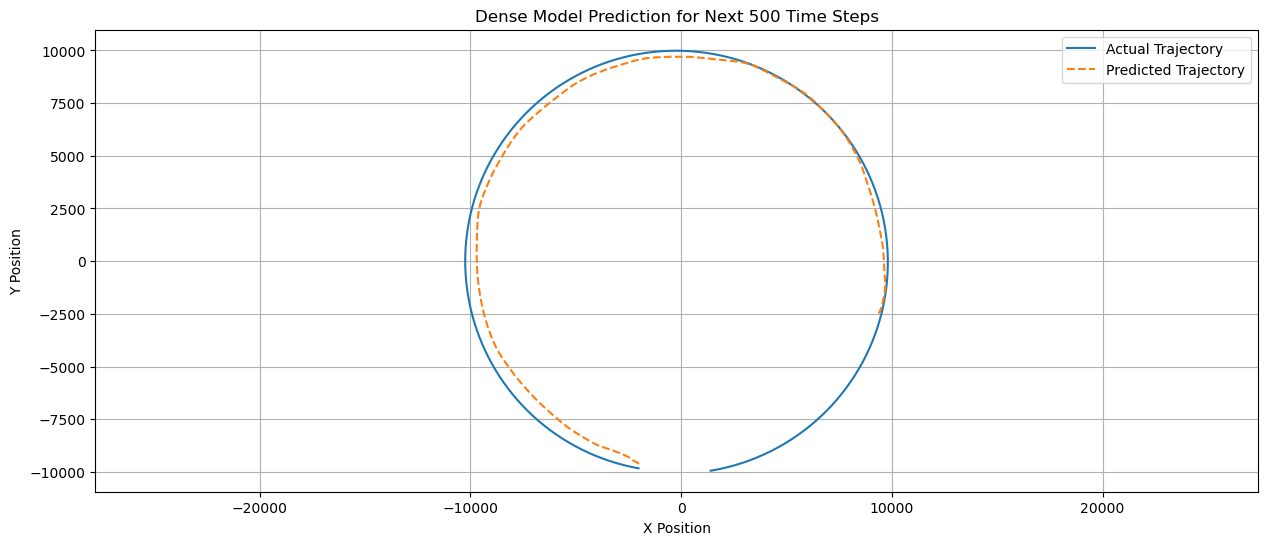

In [39]:
test_start_index = 5000
plot_predictions(predictions_10_dense, test_start_index, 10, y_test, 'Dense Model Prediction for Next 10 Time Steps', scaler_y)
plot_predictions(predictions_100_dense, test_start_index, 100, y_test, 'Dense Model Prediction for Next 100 Time Steps', scaler_y)
plot_predictions(predictions_500_dense, test_start_index, 500, y_test, 'Dense Model Prediction for Next 500 Time Steps', scaler_y)

## Two-body Problem with a second force

In [39]:
data_path = r"C:\Users\user\Downloads\Simulation_1b_1.000.csv"
data = pd.read_csv(data_path, header=None, names=["sequence", "x", "y", "vx", "vy"])
model, predictions_denorm, mae, rmse, scaler_X, scaler_y, X_test, y_test = train_and_evaluate_model(data, create_dense_regression_model)


KeyboardInterrupt: 

In [31]:
#model_save_path = r"C:\Users\user\Downloads\dense_regression_model_b_f.keras"
#model.save(model_save_path)

In [26]:
model_path = r"C:\Users\user\Downloads\dense_regression_model_b_f.keras"
model_b = load_model(model_path)

In [27]:
model_b.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,398 (142.18 KB)

 Trainable params: 12,132 (47.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,266 (94.79 KB)

In [36]:
start_input = X_test[0]  

predictions_10_dense = predict_future_steps(model, start_input, 10, scaler_X, scaler_y)
predictions_100_dense = predict_future_steps(model, start_input, 100, scaler_X, scaler_y)
predictions_500_dense = predict_future_steps(model, start_input, 500, scaler_X, scaler_y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

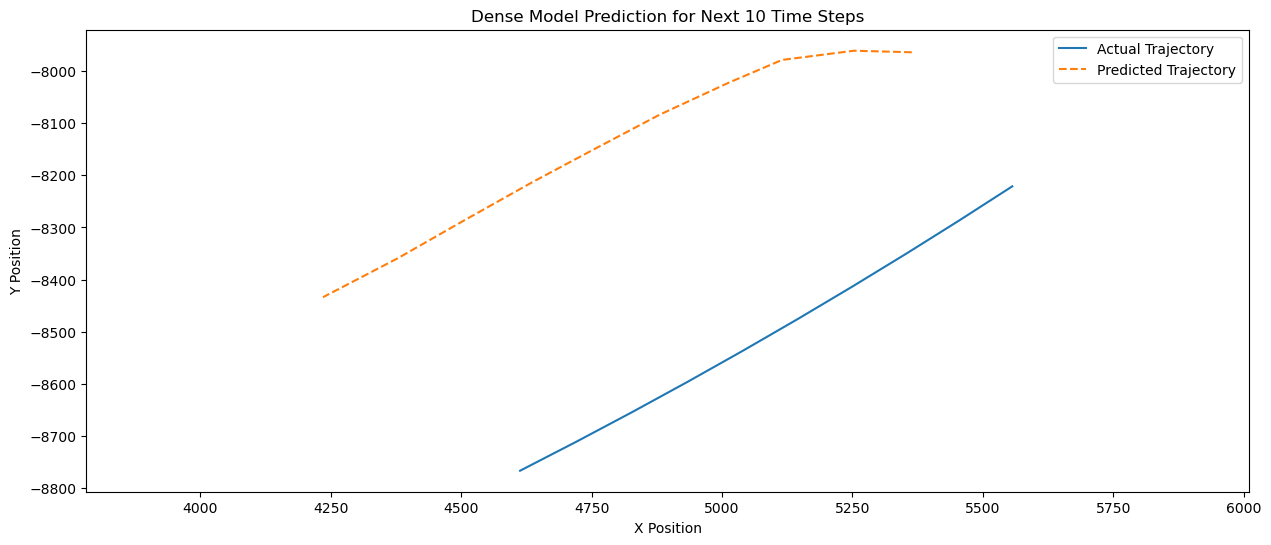

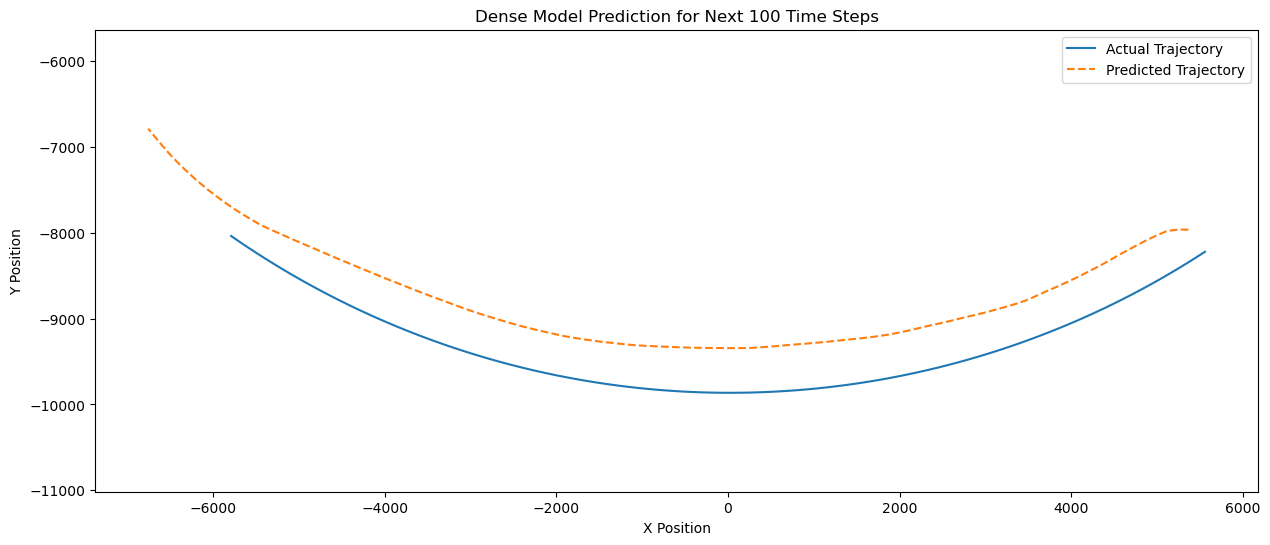

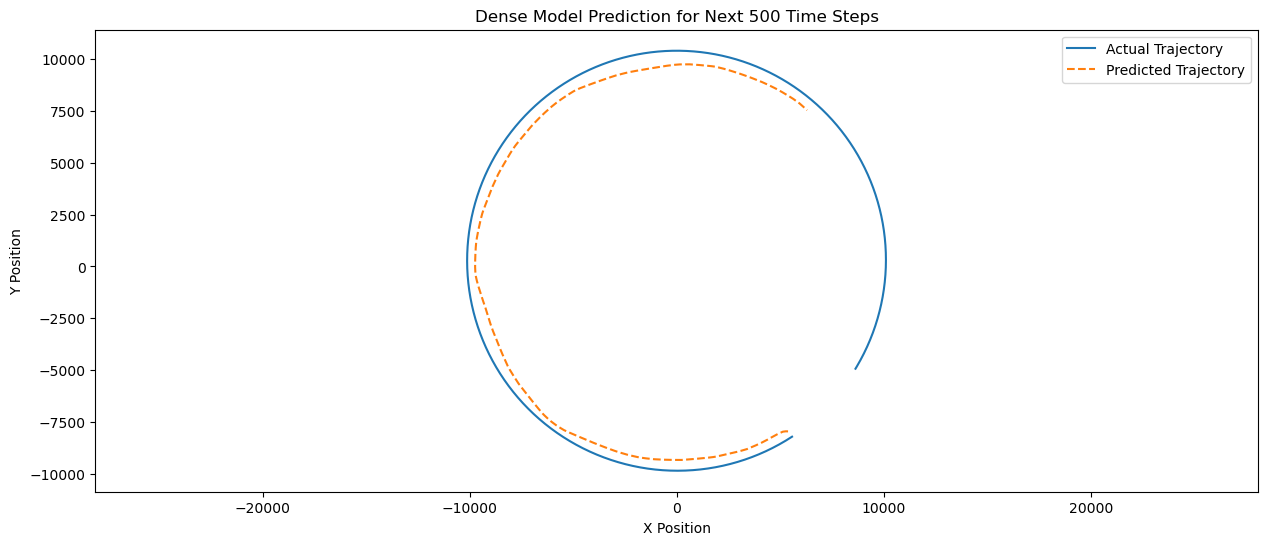

In [37]:
plot_predictions(predictions_10_dense, test_start_index, 10, y_test, 'Dense Model Prediction for Next 10 Time Steps', scaler_y)
plot_predictions(predictions_100_dense, test_start_index, 100, y_test, 'Dense Model Prediction for Next 100 Time Steps', scaler_y)
plot_predictions(predictions_500_dense, test_start_index, 500, y_test, 'Dense Model Prediction for Next 500 Time Steps', scaler_y)

## 3 Body Problem

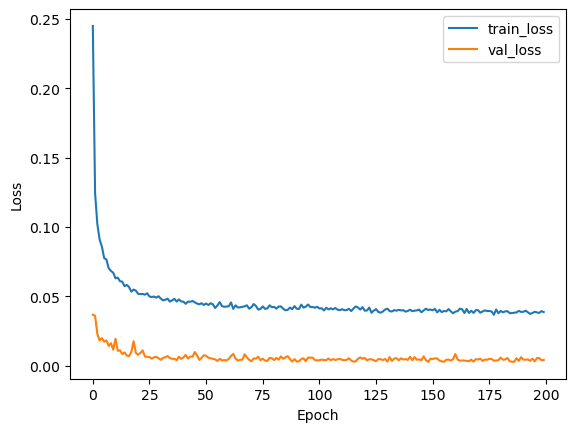

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model MAE: 8190.881105173741
Model RMSE: 15316.441190745734


In [31]:
data_path =  r"C:\Users\user\Downloads\Simulation_two_body_28751.944.csv"
data = pd.read_csv(data_path, header=None, names=["sequence", "x", "y", "vx", "vy"])
model_c, predictions_denorm, mae, rmse, scaler_X, scaler_y, X_test, y_test = train_and_evaluate_model(data,complex_dense_regression_model)

In [32]:
model_save_path = r"C:\Users\user\Downloads\dense_regression_model_c_f.keras"
model_c.save(model_save_path)

In [48]:

start_input = X_test[0]  
predictions_10_dense = predict_future_steps(model_c, start_input, 10, scaler_X, scaler_y)
predictions_100_dense = predict_future_steps(model_C, start_input, 100, scaler_X, scaler_y)
predictions_500_dense = predict_future_steps(model_C, start_input, 500, scaler_X, scaler_y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

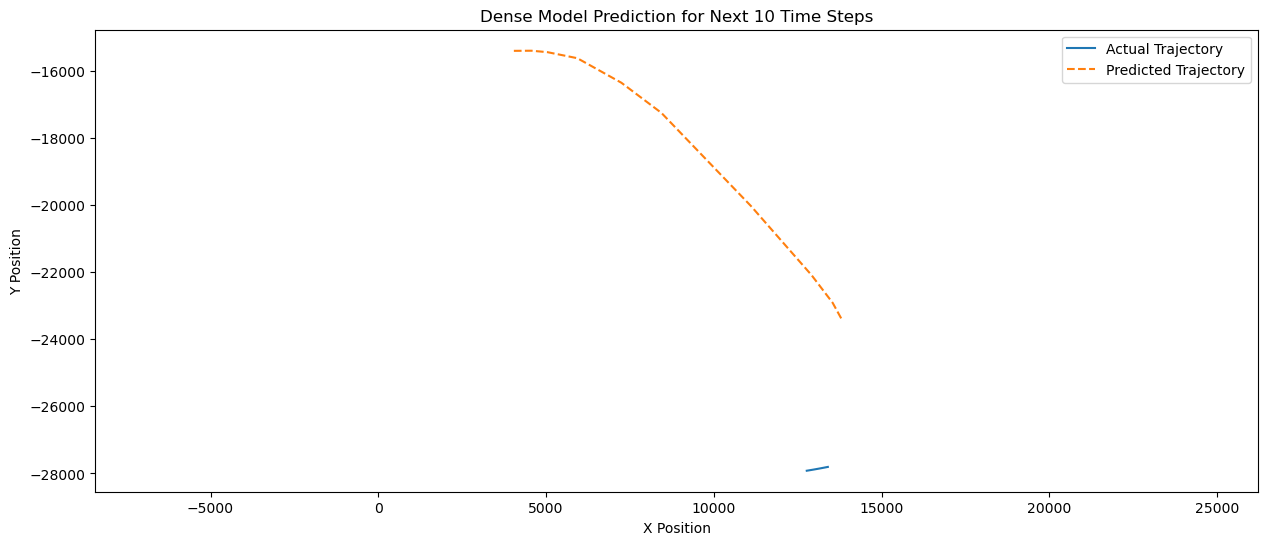

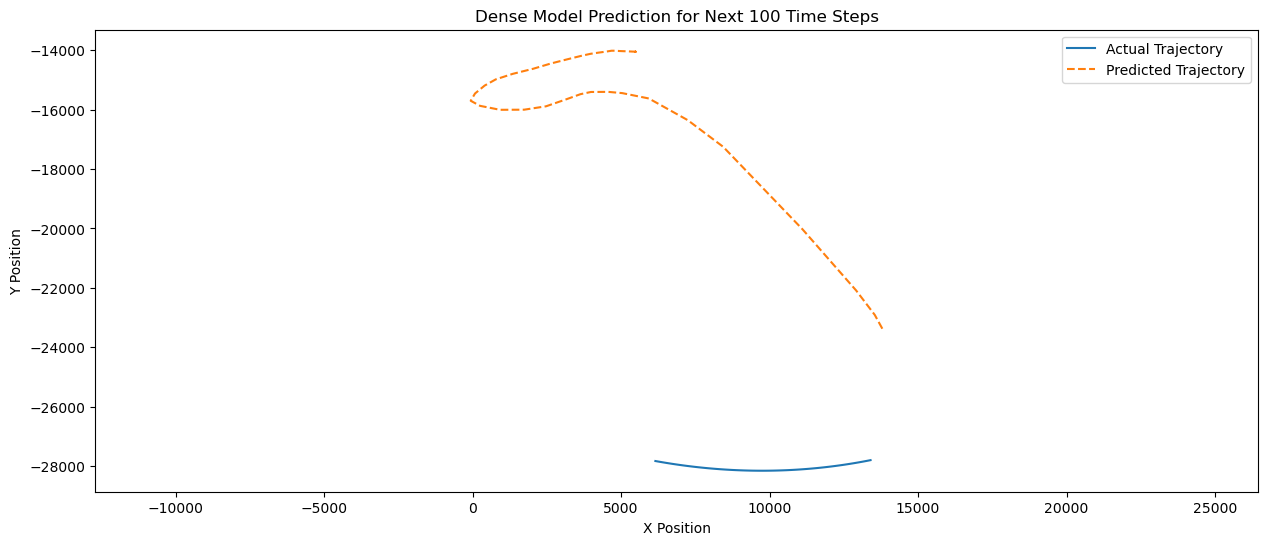

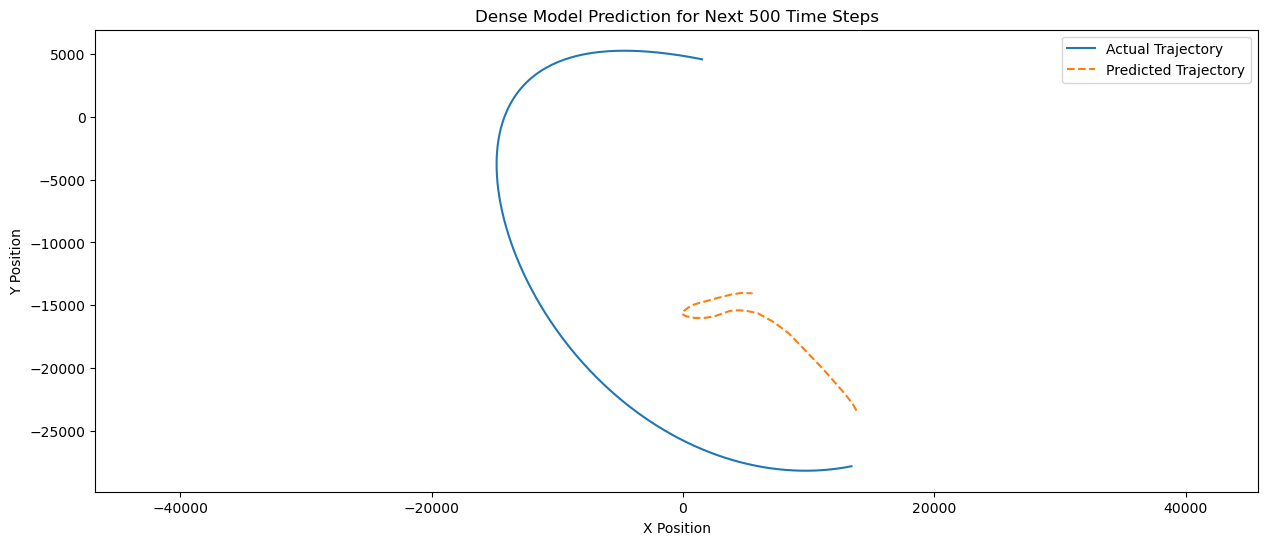

In [49]:
plot_predictions(predictions_10_dense, test_start_index, 10, y_test, 'Dense Model Prediction for Next 10 Time Steps', scaler_y)
plot_predictions(predictions_100_dense, test_start_index, 100, y_test, 'Dense Model Prediction for Next 100 Time Steps', scaler_y)
plot_predictions(predictions_500_dense, test_start_index, 500, y_test, 'Dense Model Prediction for Next 500 Time Steps', scaler_y)

## Autoregressive network

For this section a Long Short-Term Memory model (LSTM) is going to be trained but since LSTM models expect data in a specific shape (number of samples, timesteps, features) we need to create a new function for the normalization and the trainning of the model.


In [10]:
def create_and_normalize_lstm_sequences(data, n_steps=3):
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq_x = data[["x", "y", "vx", "vy"]].values[i:i+n_steps]
        seq_y = data[["x", "y", "vx", "vy"]].values[i+n_steps]
        X.append(seq_x)
        y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_reshaped = X.reshape(-1, X.shape[2])
    y_reshaped = y
    
    X_normalized = scaler_X.fit_transform(X_reshaped).reshape(X.shape)
    y_normalized = scaler_y.fit_transform(y_reshaped)
    
    return X_normalized, y_normalized, scaler_X, scaler_y


In [30]:
def create_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(128, activation='tanh', return_sequences=False),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4)  
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [31]:
def train_and_evaluate_lstm_model(data, create_model_fn, n_steps=3, test_start_index=5000, epochs=200):
    
    X, y, scaler_X, scaler_y = create_and_normalize_lstm_sequences(data, n_steps)
    X_train, X_val, X_test, y_train, y_val, y_test = splitting_data(X, y, test_start_index=test_start_index)

    # Determine the shape of the input data
    input_shape = X_train.shape[1:]
    
    
    model = create_model_fn(input_shape)
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
    
    
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    predictions = model.predict(X_test)
    predictions_denorm = scaler_y.inverse_transform(predictions)
    y_test_denorm = scaler_y.inverse_transform(y_test)
    
    
    mae = mean_absolute_error(y_test_denorm, predictions_denorm)
    rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions_denorm))
    
    print(f'LSTM Model MAE: {mae}')
    print(f'LSTM Model RMSE: {rmse}')
    
    return model, predictions_denorm, mae, rmse, scaler_X, scaler_y, X_test, y_test



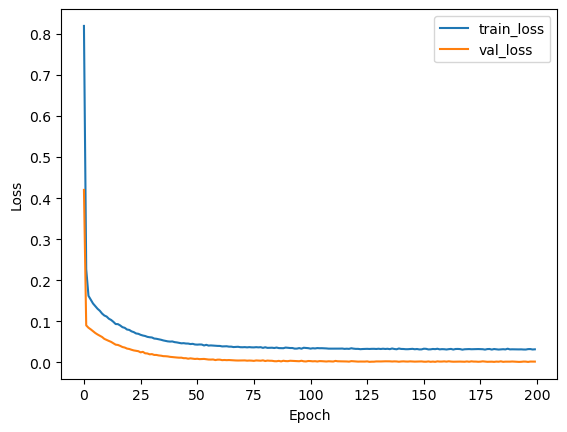

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
LSTM Model MAE: 91.93088122163526
LSTM Model RMSE: 156.40393974149794


In [32]:
data_path = r"C:\Users\user\Downloads\simulation_data_1a.csv"
data = pd.read_csv(data_path, header=None, names=["sequence", "x", "y", "vx", "vy"])
lstm_model, predictions_denorm, mae, rmse, scaler_X, scaler_y, X_test, y_test = train_and_evaluate_lstm_model(data, create_lstm_model)

In [33]:
#lstm_model_save_path = r"C:\Users\user\Downloads\lstm_model_f.keras"
#lstm_model.save(lstm_model_save_path)

In [34]:
def lstm_predict_future_steps(lstm_model, start_input, steps, scaler_X, scaler_y):
    inputs = start_input.reshape(1, start_input.shape[0], start_input.shape[1])
    predictions = []

    for step in range(steps):
        prediction = lstm_model.predict(inputs)
        predictions.append(prediction.flatten())
        # Update the input for the next prediction
        inputs = np.hstack((inputs[:, 1:, :], prediction.reshape(1, 1, -1)))  # Remove the oldest time step and add the new prediction

    return np.array(predictions)

In [35]:
start_input = X_test[0]  
predictions_10_lstm = lstm_predict_future_steps(lstm_model, start_input, 10, scaler_X, scaler_y)
predictions_100_lstm = lstm_predict_future_steps(lstm_model, start_input, 100, scaler_X, scaler_y)
predictions_500_lstm = lstm_predict_future_steps(lstm_model, start_input, 500, scaler_X, scaler_y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [59]:
def plot_trajectory(predictions, y_test, title, scaler_y):
    # Inverse transform the predictions and the test data
    predictions_denorm = scaler_y.inverse_transform(predictions)
    y_test_denorm = scaler_y.inverse_transform(y_test[:len(predictions)])

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_denorm[:, 0], y_test_denorm[:, 1], label='Actual Trajectory')
    plt.plot(predictions_denorm[:, 0], predictions_denorm[:, 1], '--', label='Predicted Trajectory')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.title(title)
    plt.axis('equal')
    plt.show()

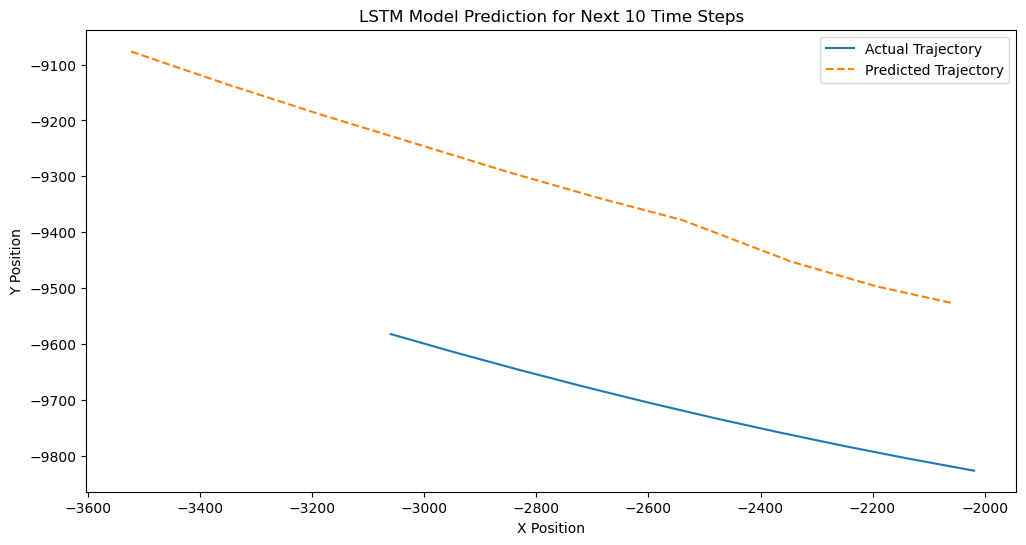

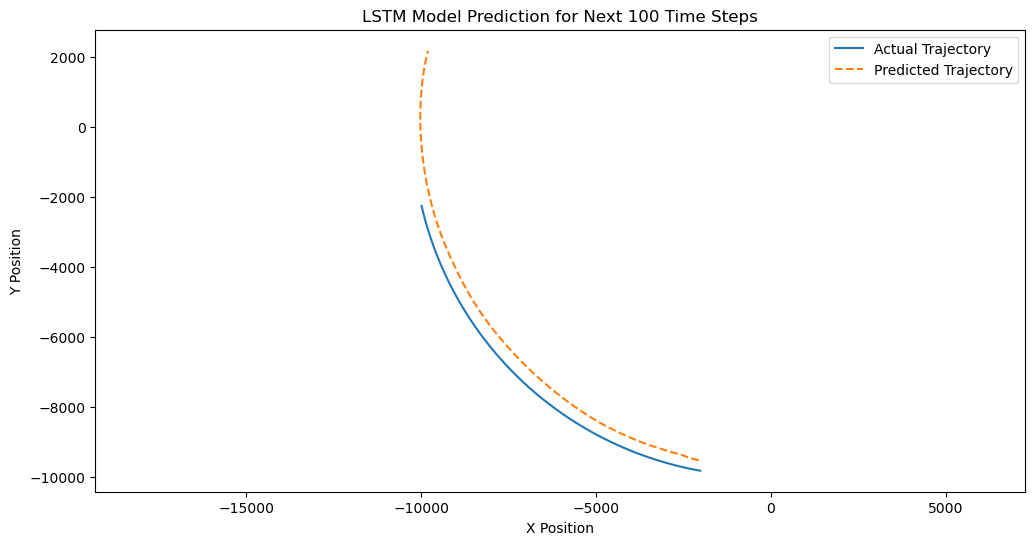

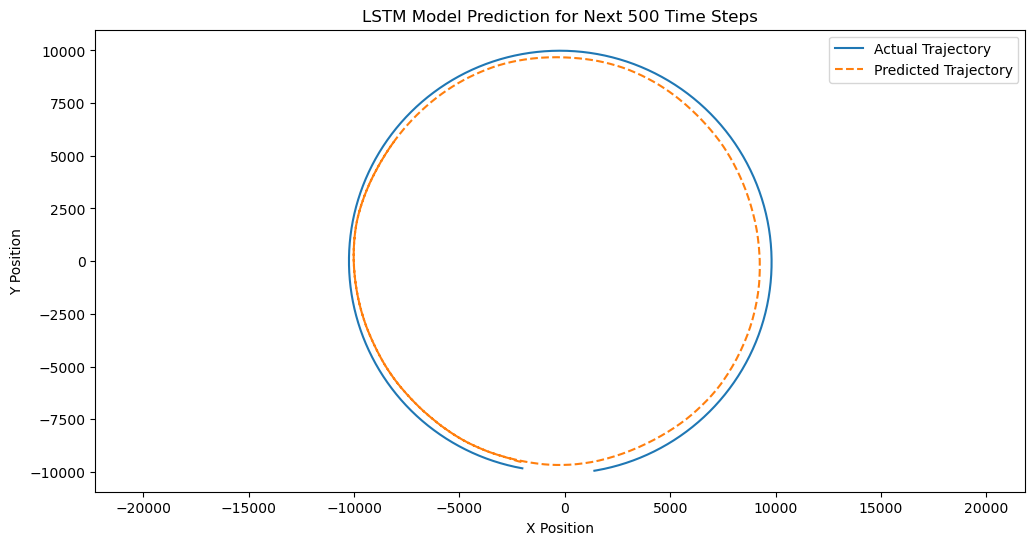

In [37]:
plot_trajectory(predictions_10_lstm, y_test, 'LSTM Model Prediction for Next 10 Time Steps', scaler_y)
plot_trajectory(predictions_100_lstm, y_test, 'LSTM Model Prediction for Next 100 Time Steps', scaler_y)
plot_trajectory(predictions_500_lstm, y_test, 'LSTM Model Prediction for Next 500 Time Steps', scaler_y)

Increasing the number of inputs to investigate the behaviour of the model

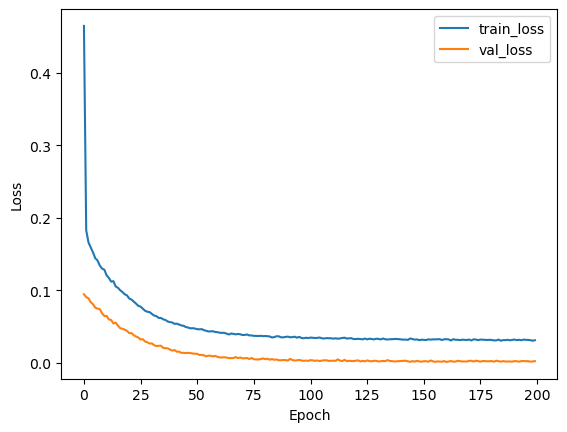

156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
LSTM Model MAE: 119.03767151110289
LSTM Model RMSE: 196.6601122841126


In [52]:
data_path = r"C:\Users\user\Downloads\simulation_data_1a.csv"
data = pd.read_csv(data_path, header=None, names=["sequence", "x", "y", "vx", "vy"])
n_steps = 13  
lstm_model_V2, predictions_denorm, mae, rmse, scaler_X, scaler_y, X_test, y_test = train_and_evaluate_lstm_model(data, create_lstm_model, n_steps=n_steps)

In [61]:
#lstm_model_V2_save_path = r"C:\Users\user\Downloads\lstm_model_f_V2.keras"
#lstm_model_V2.save(lstm_model_save_path)

In [55]:
start_input = X_test[0]  
predictions_10_lstm = lstm_predict_future_steps(lstm_model_V2, start_input, 10, scaler_X, scaler_y)
predictions_100_lstm = lstm_predict_future_steps(lstm_model_V2, start_input, 100, scaler_X, scaler_y)
predictions_500_lstm = lstm_predict_future_steps(lstm_model_V2, start_input, 500, scaler_X, scaler_y)
predictions_1000_lstm = lstm_predict_future_steps(lstm_model_V2, start_input, 1000, scaler_X, scaler_y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

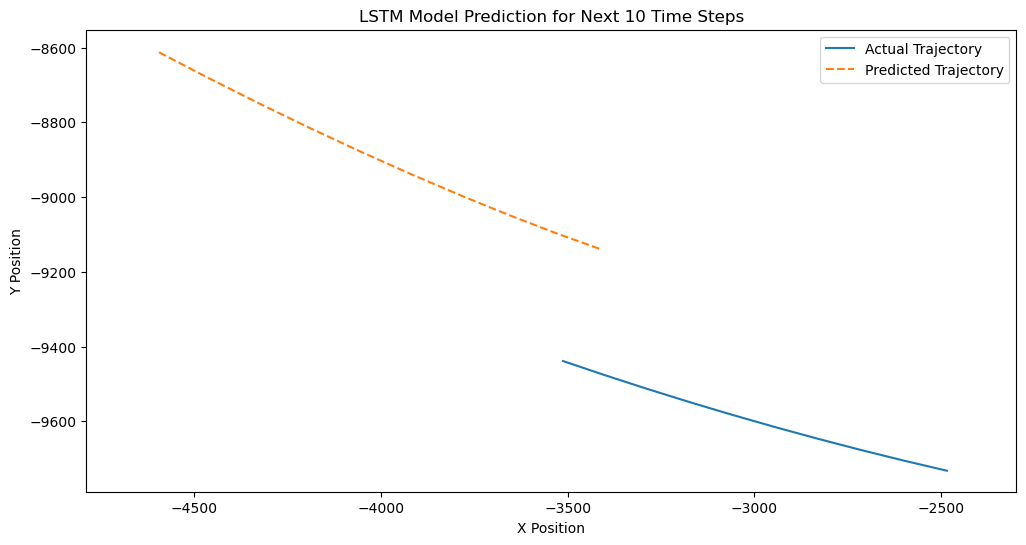

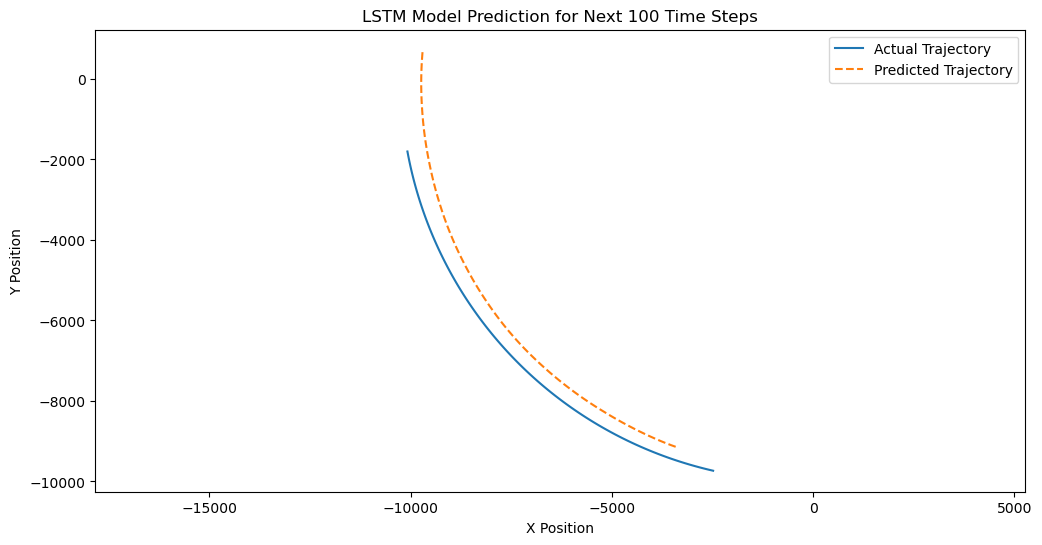

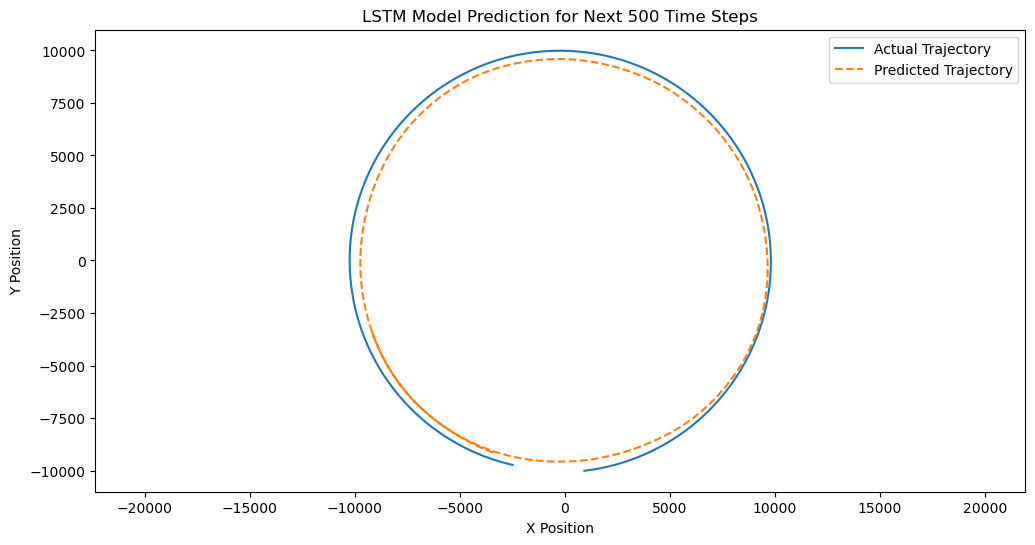

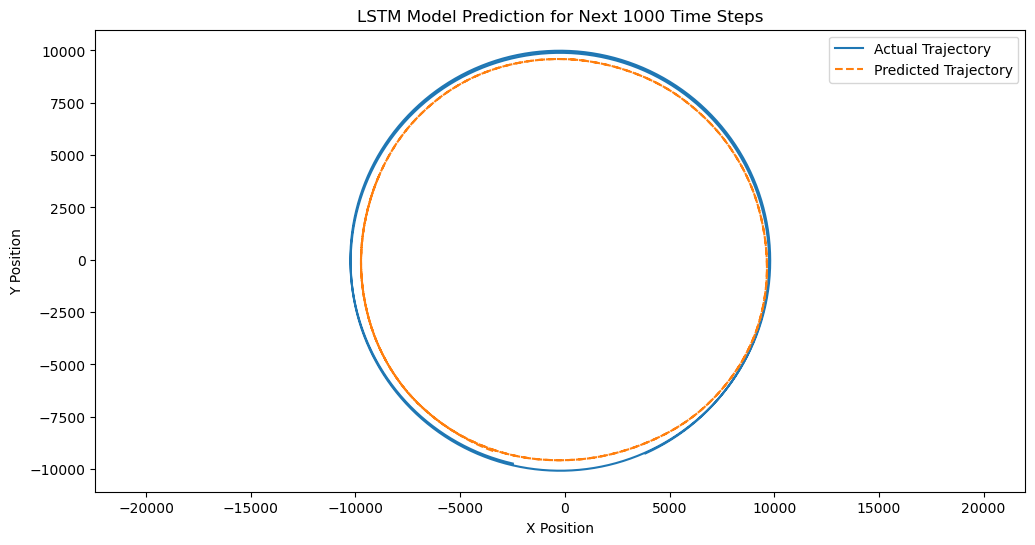

In [63]:
plot_trajectory(predictions_10_lstm, y_test, 'LSTM Model Prediction for Next 10 Time Steps', scaler_y)
plot_trajectory(predictions_100_lstm, y_test, 'LSTM Model Prediction for Next 100 Time Steps', scaler_y)
plot_trajectory(predictions_500_lstm, y_test, 'LSTM Model Prediction for Next 500 Time Steps', scaler_y)
plot_trajectory(predictions_1000_lstm, y_test, 'LSTM Model Prediction for Next 1000 Time Steps', scaler_y)


This part is not inlcude the paper I just want to check how the model behaves in different n_steps values. As it can been seen for large number of time steps the prediction are getting worse

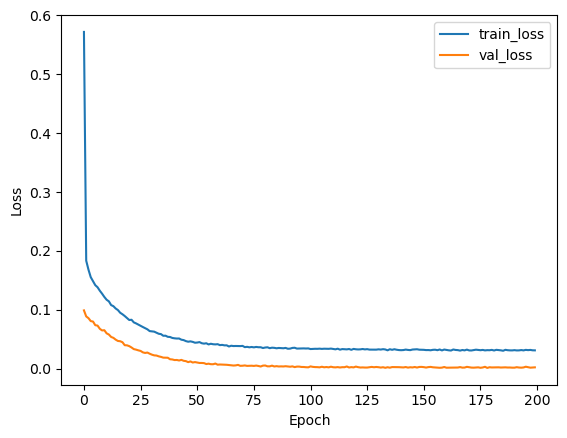

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
LSTM Model MAE: 115.27666888735172
LSTM Model RMSE: 209.1444368470651


In [60]:
data_path = r"C:\Users\user\Downloads\simulation_data_1a.csv"
data = pd.read_csv(data_path, header=None, names=["sequence", "x", "y", "vx", "vy"])
n_steps = 7  # Updated n_steps value
lstm_model_V3, predictions_denorm, mae, rmse, scaler_X, scaler_y, X_test, y_test = train_and_evaluate_lstm_model(data, create_lstm_model, n_steps=n_steps)

In [62]:
#lstm_model_V3_save_path = r"C:\Users\user\Downloads\lstm_model_f_V3.keras"
#lstm_model_V3.save(lstm_model_save_path)

In [64]:
predictions_10_lstm = lstm_predict_future_steps(lstm_model_V3, start_input, 10, scaler_X, scaler_y)
predictions_100_lstm = lstm_predict_future_steps(lstm_model_V3, start_input, 100, scaler_X, scaler_y)
predictions_500_lstm = lstm_predict_future_steps(lstm_model_V3, start_input, 500, scaler_X, scaler_y)
predictions_1000_lstm = lstm_predict_future_steps(lstm_model_V3, start_input, 1000, scaler_X, scaler_y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

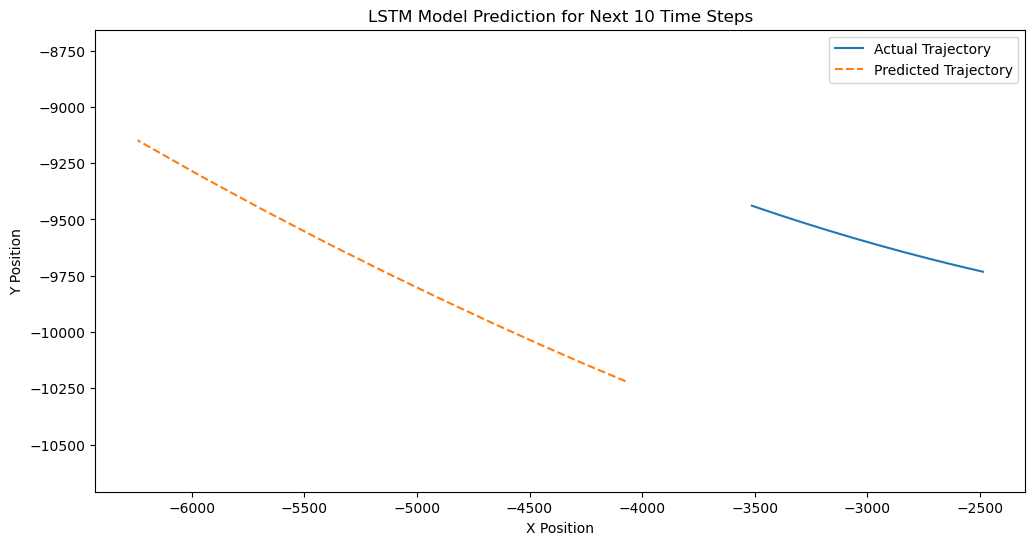

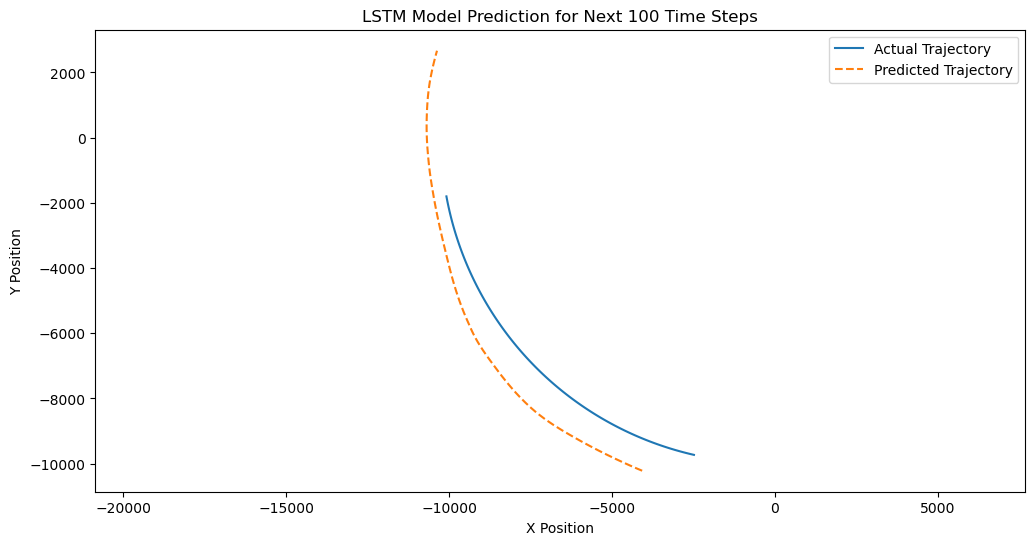

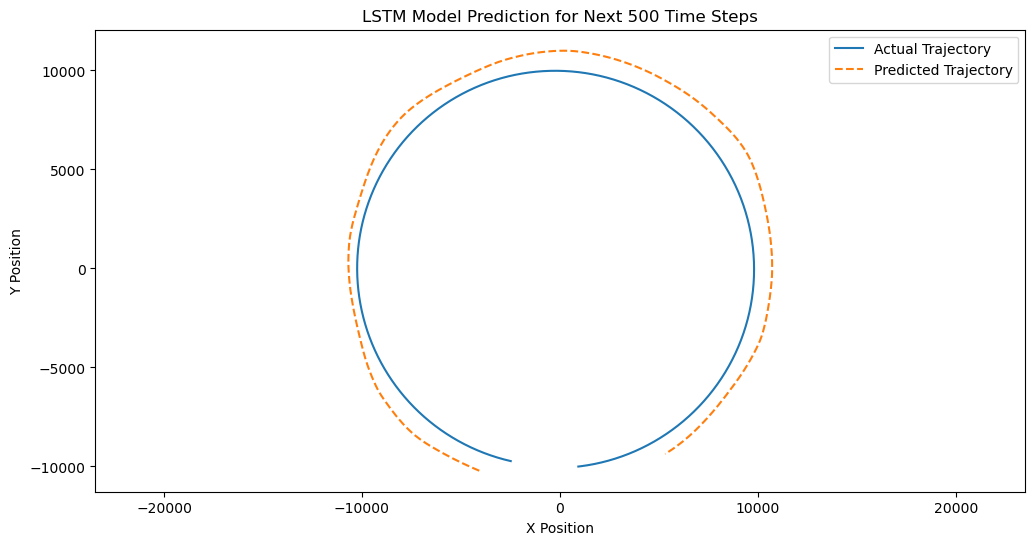

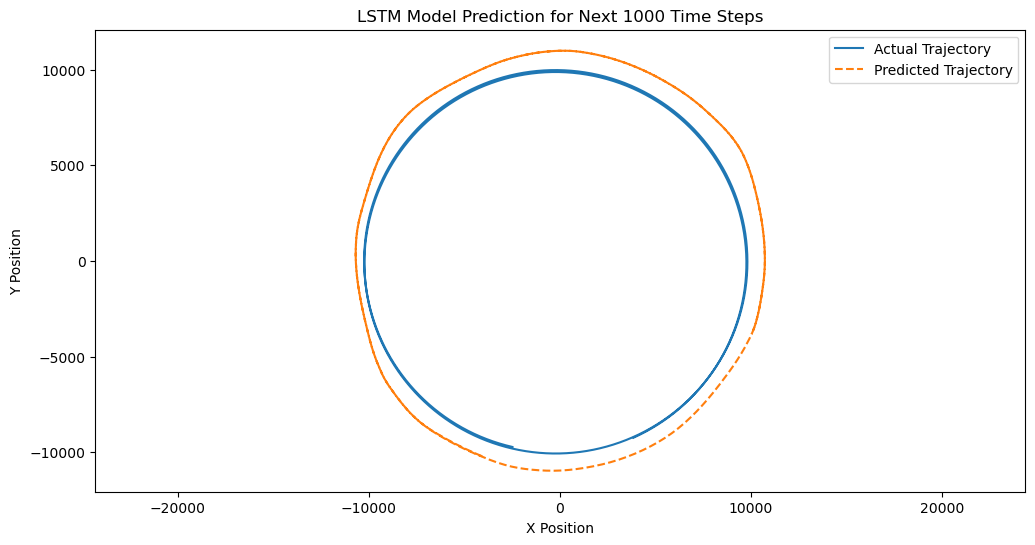

In [65]:
plot_trajectory(predictions_10_lstm, y_test, 'LSTM Model Prediction for Next 10 Time Steps', scaler_y)
plot_trajectory(predictions_100_lstm, y_test, 'LSTM Model Prediction for Next 100 Time Steps', scaler_y)
plot_trajectory(predictions_500_lstm, y_test, 'LSTM Model Prediction for Next 500 Time Steps', scaler_y)
plot_trajectory(predictions_1000_lstm, y_test, 'LSTM Model Prediction for Next 1000 Time Steps', scaler_y)
